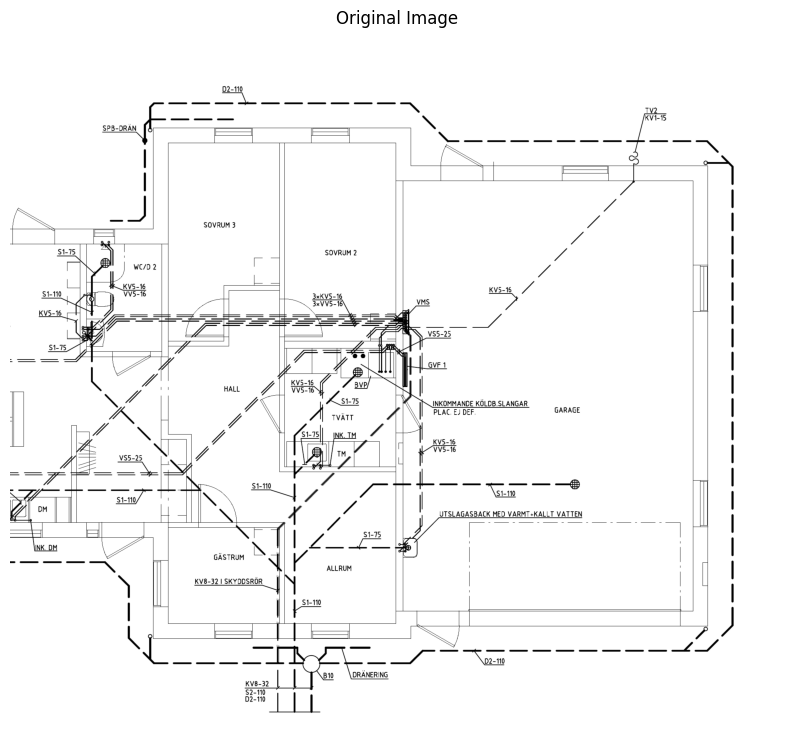

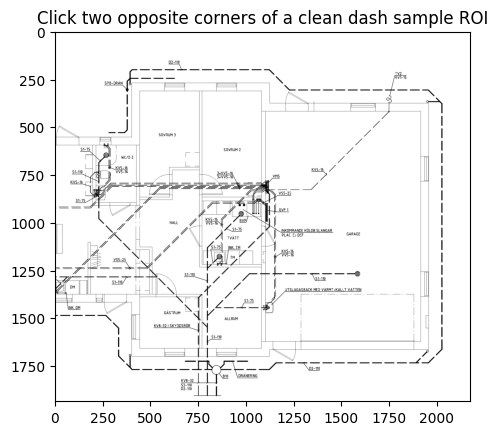

IndexError: list index out of range

In [1]:
# dashed_line_detection.ipynb
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops
from scipy.signal import find_peaks
from math import atan2, degrees
import ipywidgets as widgets
from IPython.display import display

# === Step 1: Load image ===
img_path = "rightside.png"  # Change to your file path
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Preview
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

# === Step 1: ROI Picker for sample dash ===
coords = []

def onclick(event):
    if event.xdata and event.ydata:
        coords.append((int(event.xdata), int(event.ydata)))
        if len(coords) == 2:
            plt.close()

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.set_title("Click two opposite corners of a clean dash sample ROI")
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

x1, y1 = coords[0]
x2, y2 = coords[1]
roi = img[min(y1,y2):max(y1,y2), min(x1,x2):max(x1,x2)]

plt.figure()
plt.imshow(roi, cmap='gray')
plt.title("ROI Sample")
plt.axis('off')
plt.show()

# === Step 1b: Estimate stroke width, dash length, gap ===
# Binarize ROI
_, roi_bin = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Stroke width via distance transform
dist = cv2.distanceTransform(roi_bin, cv2.DIST_L2, 3)
stroke_width = int(np.median(dist[roi_bin > 0]) * 2)

# Estimate dash length and gap using projection along major axis
# Orientation
ys, xs = np.where(roi_bin > 0)
cov = np.cov(xs, ys)
eigvals, eigvecs = np.linalg.eig(cov)
main_axis = eigvecs[:, np.argmax(eigvals)]
angle = np.arctan2(main_axis[1], main_axis[0])
rot_mat = cv2.getRotationMatrix2D((roi_bin.shape[1]//2, roi_bin.shape[0]//2),
                                  -np.degrees(angle), 1.0)
roi_rot = cv2.warpAffine(roi_bin, rot_mat, (roi_bin.shape[1], roi_bin.shape[0]))

# Project along axis
proj = np.sum(roi_rot > 0, axis=0)
proj_norm = (proj - np.min(proj)) / (np.max(proj)-np.min(proj) + 1e-5)
peaks, _ = find_peaks(proj_norm, height=0.5, distance=2)

if len(peaks) > 1:
    period = np.median(np.diff(peaks))
    dash_len = np.mean([np.sum(proj_norm[p] > 0.5) for p in peaks])
    gap_len = period - dash_len
else:
    dash_len, gap_len = stroke_width * 3, stroke_width * 2  # fallback guess

print(f"Stroke width ~ {stroke_width}px, dash length ~ {dash_len:.1f}px, gap length ~ {gap_len:.1f}px")

# === Step 2: Preprocess whole image ===
# CLAHE for contrast
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_eq = clahe.apply(img)

# Binary mask
_, img_bin = cv2.threshold(img_eq, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# === Step 3: Width gating ===
dist_full = cv2.distanceTransform(img_bin, cv2.DIST_L2, 3)
mask_width = ((dist_full >= (stroke_width-1)/2) & (dist_full <= (stroke_width+1)/2)).astype(np.uint8) * 255

# === Step 3b: Matched filtering ===
def make_line_kernel(length, thickness, angle_deg):
    kernel = np.zeros((length, length), np.uint8)
    cv2.line(kernel, (0, length//2), (length-1, length//2), 1, thickness)
    M = cv2.getRotationMatrix2D((length//2, length//2), angle_deg, 1.0)
    kernel = cv2.warpAffine(kernel.astype(np.float32), M, (length, length))
    return kernel

angles = np.arange(0, 180, 10)
match_mask = np.zeros_like(mask_width)
for ang in angles:
    kern = make_line_kernel(int(max(dash_len, stroke_width*3)), stroke_width, ang)
    res = cv2.filter2D(mask_width, cv2.CV_32F, kern)
    match_mask[(res > np.max(res)*0.5)] = 255

# === Step 3c: Periodicity filter ===
# (Very simple version: skip for now in PoC)

# === Step 4: Skeletonize and vectorize ===
skeleton = skeletonize(match_mask > 0)
labeled = label(skeleton)
props = regionprops(labeled)

polylines = []
for p in props:
    coords_poly = [(y, x) for (y, x) in p.coords]
    polylines.append(coords_poly)

# Visualize
overlay = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for poly in polylines:
    for pt in poly:
        overlay[pt] = (0,0,255)  # red

plt.figure(figsize=(10,10))
plt.imshow(overlay)
plt.title("Detected Bold Dashed Lines")
plt.axis('off')
plt.show()
